In [3]:
from radio_z import hifit, saxdata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%matplotlib nbagg

Read in the catalogue with the SAX parameters from an HDF5 file

In [4]:
rt = '/home/michelle/Project/HI_fit/sub_z/cats/'
name = 'snr5_cat'
cat_name = rt+name+'.h5'

In [5]:
surv = saxdata.Survey('ska1_band1')
cat = saxdata.SaxCatalogue(cat_name)
cat_df = cat.get_data()

Create the mock HI data from the SAX parameters for the whole catalogue

In [6]:
make_new_data = False
data_maker = saxdata.DataFromCatalogue()

if make_new_data:
    dat = data_maker.create_from_cat(cat_df, surv, rt+name+'_data.hdf5')
else:
    dat = pd.HDFStore(rt+name+'_data.hdf5')

In [58]:
ind = dat.keys()[2]
df = dat[ind]
dat

<class 'pandas.io.pytables.HDFStore'>
File path: /home/michelle/Project/HI_fit/sub_z/cats/snr5_cat_data.hdf5
/ID72817050            frame        (shape->[70000,3])
/ID72865443            frame        (shape->[70000,3])
/ID73023115            frame        (shape->[70000,3])
/ID79949832            frame        (shape->[70000,3])
/ID93408331            frame        (shape->[70000,3])

Each object is stored in a separate dataframe in the HDF5 file. We can plot an example profile to have a look.

<IPython.core.display.Javascript object>


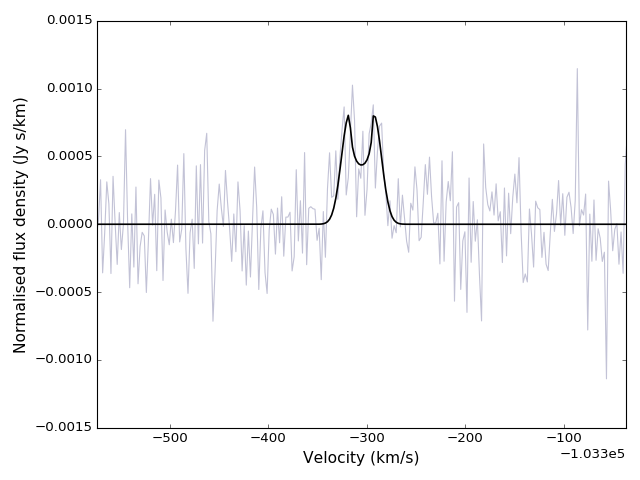

In [59]:
plt.figure()
data_maker.plot_profile(df, plot_model=True, model_params=cat.get_params(cat_df,ind[1:]))

This object allows us to fit the whole catalogue, in parallel if requested

In [60]:
fc = hifit.FitCatalogue(dat)

In [61]:
run_multinest = False #In case we've already run these

In [62]:
if run_multinest:
    fc.fit_all(nprocesses=5, output_dir='/home/michelle/BigData/HI_output/')

You can use the ChainAnalyser object to run useful analyses, such as getting the best fit estimates of the parameters, the errors (in terms of 16% and 84% marginals) and P(z) as a histogram. Here we print out the bias for each parameter for each object, measured in n sigma.

In [73]:
An = hifit.ChainAnalyser('/home/michelle/BigData/HI_output/'+ind+'-')


In [86]:
%autoreload

<IPython.core.display.Javascript object>


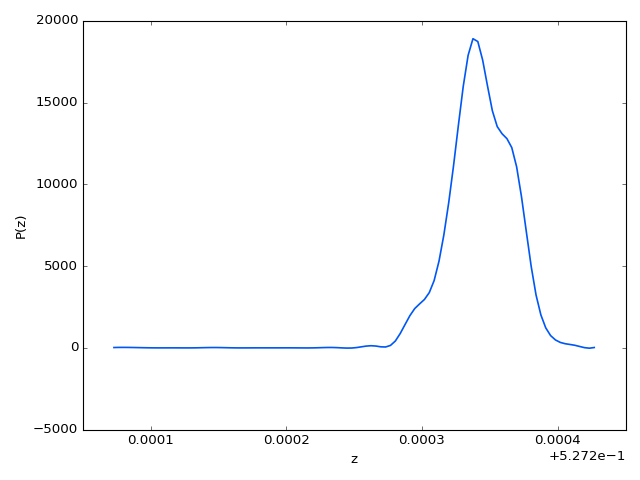

In [87]:
plt.figure()
An.plot_p_of_z(smooth=True)

In [88]:
ests.to

,Mean,Median,MAP,16p,84p
v0,-1.018807e+05,-101939.673952,0.000000e+00,-101942.178303,-101938.655343
w_obs_20,7.070698e+23,76.057753,4.293898e+24,68.064946,86.146410
w_obs_50,1.723652e+23,56.902884,2.177971e+23,45.302918,66.650748
w_obs_peak,1.385096e+01,14.429624,4.782478e+00,9.156662,16.692684
psi_obs_max,-7.151224e+00,-7.182267,6.209053e-04,-7.380548,-6.923154
psi_obs_0,-9.678326e+00,-9.742384,1.095540e-04,-10.598243,-8.788494
z,5.143939e-01,0.514690,-0.000000e+00,0.514682,0.514709


In [13]:
for i in list(cat_df.id):
    An = hifit.ChainAnalyser('/home/michelle/BigData/HI_output/'+i+'-')
    ests = An.parameter_estimates()
    fit_params = ests['MAP'][:-1].as_matrix()
    sig = ((ests['84p'][:-1].as_matrix()-fit_params)+(fit_params-ests['16p'][:-1].as_matrix()))/2
    model_params=cat.get_params(cat_df,i)
    print(model_params, fit_params)
    #print('z: ',ests.loc['z','MAP'],ests.loc['z','16p'],ests.loc['z','84p'])

[ -1.09241608e+05   5.22000000e+01   4.22000000e+01   2.27000000e+01
   8.33330000e-04   5.04340000e-04] [ -1.09243629e+05   5.90598050e+01   3.74113294e+01   1.32667350e+01
   1.18880834e-03   3.83361555e-04]
[ -1.02726322e+05   1.24000000e+02   1.13000000e+02   9.08000000e+01
   5.77500000e-04   2.30010000e-04] [ -1.02727558e+05   1.12544693e+02   1.03949474e+02   9.32141990e+01
   1.03776614e-03   2.54937868e-04]
[ -1.01943986e+05   6.06000000e+01   5.05000000e+01   3.08000000e+01
   8.03390000e-04   3.42930000e-04] [ -1.01939749e+05   7.16629753e+01   5.00884056e+01   1.46534336e+01
   8.88770039e-04   2.02178262e-05]
[ -1.19844165e+05   3.53000000e+01   2.53000000e+01   6.27000000e+00
   4.94010000e-04   4.94010000e-04] [ -1.55330594e+05   1.08479946e+03   9.38824068e+02   8.00173899e+02
   1.73202860e-04   1.74221686e-05]
[ -1.03605283e+05   5.36000000e+01   4.36000000e+01   2.41000000e+01
   8.23350000e-04   4.42200000e-04] [ -1.03610708e+05   6.20748601e+01   6.00579289e+01   2

In [26]:
from collections import OrderedDict
v0=cat.get_params(cat_df, ind[1:])[0]
delt = 15000
bounds = OrderedDict([
                    ('v0', [v0-delt, v0+delt]),
                    ('w_obs_20', [0, 1500]),
                    ('w_obs_50', [0, 1500]),
                    ('w_obs_peak', [0, 1500]),
                    ('psi_obs_max', [-11, -2]),
                    ('psi_obs_0', [-11, -2])
                ])

In [94]:
%autoreload

In [95]:
fd=hifit.FitData(df.v.as_matrix(),df.psi.as_matrix(),df.psi_err.as_matrix())

In [96]:
fd.fit(chain_name='/home/michelle/BigData/HI_output/'+ind[1:]+'-', convert_to_binary=True)

Time taken 3.892238473892212 minutes


In [121]:
%autoreload

<IPython.core.display.Javascript object>


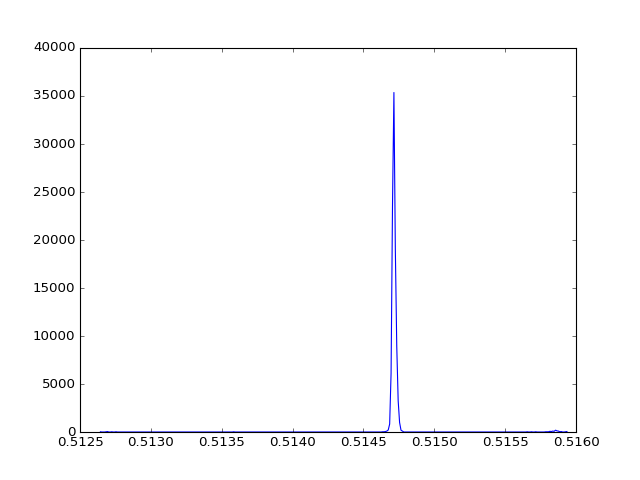

In [126]:
b,p = An.p_of_z(delta_z=0.00001)
plt.figure()
plt.plot(b,p)

In [49]:
%autoreload

<IPython.core.display.Javascript object>


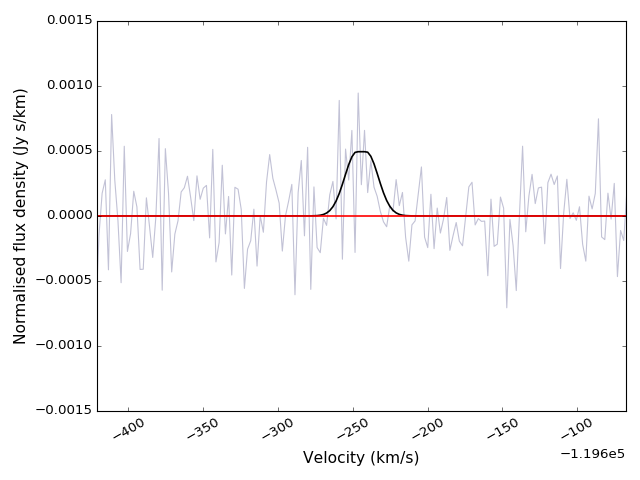

In [146]:
data_maker.plot_profile(df, plot_model=True, model_params=model_params, plot_fit=True, fit_params=fit_params,
                        zoom=True, rotation=30)

# Scratch

In [53]:
import pandas as pd

In [57]:
d = pd.read_csv('/home/michelle/Project/HI_fit/sub_z/91a09e81829d518c605c4601c9e52a7797d5e545.result')

In [71]:
d.hilumcenter.max()

0.0499

In [72]:
np.exp(-1)

0.36787944117144233

In [153]:
import os
pth='/home/michelle/BigData/HI_output/'
fls=os.listdir(pth)
for f in fls:
    if f[0] == ':':
        os.system('mv '+pth+f+' '+pth+f[1:])

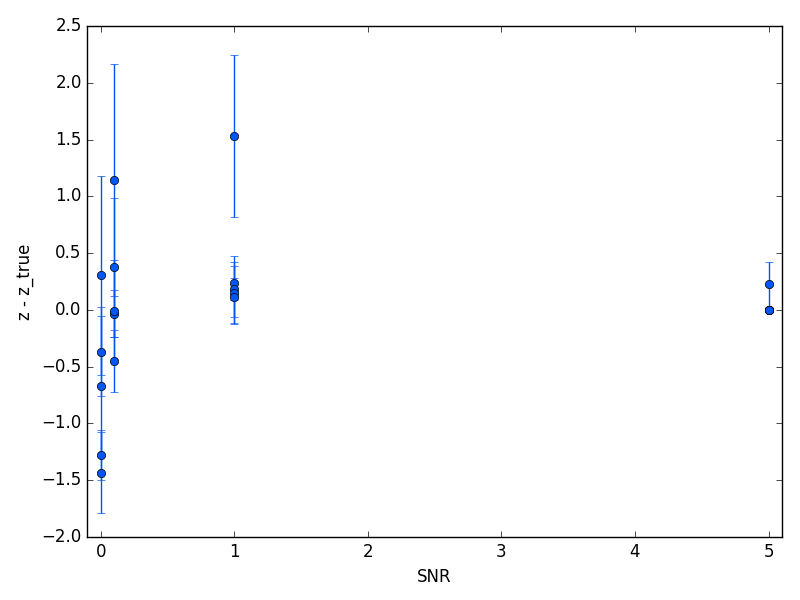

In [90]:
from IPython.display import Image
Image(filename='/home/michelle/BigData/HI_output/snr_analysis/SNR_vs_z.png') 